In [1]:
import os
import pandas as pd
import math
import pickle

In [2]:
from __future__ import unicode_literals
from __future__ import division
import copy
import gc
import numpy as np
import pdb as check
import random
# import modelfunctions
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC

C:\Users\why\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\why\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor

In [3]:
def svm_c(x_train, x_test, y_train, y_test):
    clf = SVC(C=0.001, kernel='rbf', probability = True, class_weight='balanced')    # 
#     clf = SVC(C=0.005, kernel='rbf', probability = True, class_weight='balanced')    # 0.9451
#     clf = SVC(C=0.01, kernel='rbf', probability = True, class_weight='balanced')    # 0.9451
#     clf = SVC(C=0.05, kernel='rbf', probability = True, class_weight='balanced')    # 0.9444
#     clf = SVC(C=0.1, kernel='rbf', probability = True, class_weight='balanced')     # 0.9423
#     clf = SVC(C=0.5, kernel='rbf', probability = True, class_weight='balanced')       # 0.9337
#     clf = SVC(C=1.0, kernel='rbf', probability = True, class_weight='balanced')     # 0.9318
    clf.fit(x_train, y_train)
    predict = clf.predict_proba(x_test)
    return predict, clf
    

In [4]:
file_path = './Data/days_after_mainshock_360/'

In [5]:
feat_columns = ['aftershock_mag', 'sxx', 'syy', 'szz', 'syz', 'sxz', 'sxy', 'coulomb', 'maxshear', 'von']

In [6]:
add_self, add_sqrt, add_abs, add_physic, add_log = False, False, True, True, True

In [7]:
def get_filename(filepath = file_path):
    file_list = []
    for filename in os.listdir(filepath):
        file_list.append(filename)
    return file_list
file_list = get_filename()
print(len(file_list))

175


In [8]:
mag_range = [3.0, 5.0, 5.5, 6.0, 8.0]
dis_range = [0, 20, 40, 60, 100000]

In [9]:
def get_sample(file_list, col_list, filepath=file_path, add_self=add_self, add_sqrt=add_sqrt, add_abs=add_abs, add_physic=add_physic,add_log=add_log):
    new_col = ['aftershock_mag']
    if add_self:
        for col in col_list[1::]:
            new_col.append(col)
    if add_abs:
        for col in col_list[1::]:
            if col in ['sxx', 'syy', 'szz', 'syz', 'sxz', 'sxy']:
                new_col.append("abs_"+col)
    if add_sqrt:
        for col in col_list[1::]:
            if col in ['sxx', 'syy', 'szz', 'syz', 'sxz', 'sxy']:
                new_col.append("sqrt_"+col)
    if add_physic:
        for col in col_list[1::]:
            if col in ['coulomb', 'maxshear', 'von']:
                new_col.append('abs_'+col)
    if add_log:
        for col in col_list[1::]:
            if col in ['sxx', 'syy', 'szz', 'syz', 'sxz', 'sxy']:
                new_col.append("log_"+col)            
    raw_data = None  
    for file in file_list:
        main_Mag = float(file.strip('.csv').split('-')[1][1::])
        df = pd.read_csv(filepath+file, header=0)
        axis = np.where(np.isnan(df))
        if len(axis[0]) != 0:
            print("%s is wrong" % file)
            continue
        unique = df['aftershock_mag'].unique()
        if(len(unique)==1):
            continue
        
        index = len(df.columns)
        columns = df.columns.copy()
        for col in columns:
            df.insert(index, '-'+col, -df[col])
            df.insert(index+1, 'abs_'+col, abs(df[col]))
            df.insert(index+2, '-abs_'+col, -abs(df[col]))
            col_sqrt = df[col].apply(lambda x: math.sqrt(abs(x)))
            df.insert(index+3, 'sqrt_'+col, col_sqrt)
            df.insert(index+4, '-sqrt_'+col, -col_sqrt)
            col_log = df[col].apply(lambda x: np.log(abs(x)+1))
            df.insert(index+5, 'log_'+col, col_log)
            df.insert(index+6, '-log_'+col, -col_log)
            
        for idx in range(len(mag_range) - 1):
            if main_Mag >= mag_range[idx] and main_Mag < mag_range[idx+1]:
                break
        mainMag_oneHot = [[0]*(len(mag_range)-1)]
        mainMag_oneHot[0][idx] = 1
        mainMag_oneHot = mainMag_oneHot * len(df)
        index = len(df.columns)
        mainMag_oneHot = np.array(mainMag_oneHot)
        for idx in range(len(mag_range)-1):
            df.insert(index+idx, 'mainMag_oneHot_'+str(idx), mainMag_oneHot[:, idx])
        
        dis_oneHot = []
        for x, y in zip(df['x'].values, df['y'].values):
#             print(x, y)
            dis = math.sqrt(x*x + y*y)
            for idx in range(len(dis_range)-1):
                if dis >= dis_range[idx] and dis < dis_range[idx+1]:
                    break
            dis_oneHot_tmp = [0]*(len(dis_range)-1)
            dis_oneHot_tmp[idx] = 1
            dis_oneHot.append(dis_oneHot_tmp)

        index = len(df.columns)
        dis_oneHot = np.array(dis_oneHot)
        for idx in range(len(dis_range)-1):
            df.insert(index+idx, 'dis_oneHot_'+str(idx), dis_oneHot[:, idx])
        if raw_data is None:
            raw_data = df
        else:
            raw_data = raw_data.append(df)
    
    if raw_data is None:
        return raw_data
    if len(raw_data) == 0:
        return raw_data[new_col]

    for idx in range(len(mag_range)-1):
        new_col.append('mainMag_oneHot_'+str(idx))
    for idx in range(len(dis_range)-1):
        new_col.append('dis_oneHot_'+str(idx))
    
    raw_data = raw_data[new_col]
    return raw_data

In [10]:
cnt = len(file_list)
Index = [i for i in range(cnt)]
random.seed(21)
random.shuffle(Index)
print(Index)

[82, 48, 61, 69, 92, 164, 145, 7, 156, 117, 80, 144, 146, 123, 78, 6, 53, 103, 36, 95, 150, 1, 50, 81, 172, 88, 126, 51, 27, 143, 12, 45, 101, 136, 2, 132, 16, 170, 157, 115, 30, 151, 83, 90, 35, 56, 168, 58, 153, 24, 32, 79, 67, 89, 169, 65, 152, 133, 158, 137, 100, 33, 106, 4, 91, 166, 54, 140, 163, 85, 13, 139, 141, 75, 174, 44, 21, 23, 14, 110, 118, 77, 73, 28, 66, 76, 70, 148, 119, 161, 63, 20, 11, 160, 34, 98, 62, 40, 108, 64, 57, 165, 155, 52, 68, 18, 43, 125, 49, 105, 112, 128, 71, 15, 130, 93, 74, 167, 97, 96, 147, 114, 134, 86, 26, 25, 99, 19, 171, 120, 9, 47, 38, 124, 102, 87, 41, 116, 142, 31, 22, 39, 5, 159, 29, 127, 138, 84, 8, 113, 104, 111, 10, 154, 59, 37, 17, 109, 149, 94, 3, 0, 60, 135, 129, 46, 131, 121, 55, 122, 72, 162, 173, 107, 42]


In [11]:
from sklearn import metrics as sk_metrics

20151207-M7.2.csv is wrong
20011114-M7.8.csv is wrong
5361


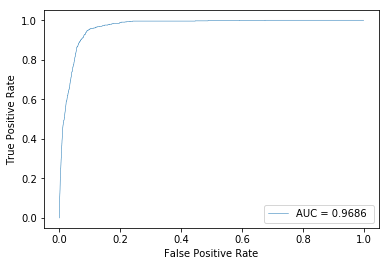

20011114-M7.8.csv is wrong
20151207-M7.2.csv is wrong
5390


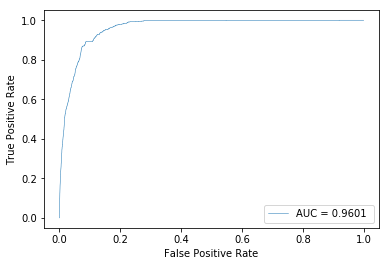

20011114-M7.8.csv is wrong
20151207-M7.2.csv is wrong
4923


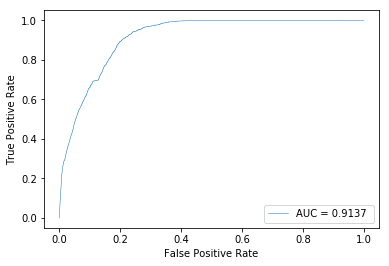

20011114-M7.8.csv is wrong
20151207-M7.2.csv is wrong
4476


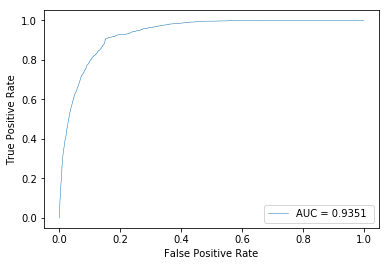

20011114-M7.8.csv is wrong
20151207-M7.2.csv is wrong
5074


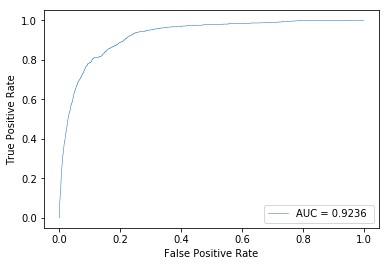

In [12]:
def main():
    fold_cnt = 5
    AUC_list = []
    Test_label_list,Test_predictProb_list = [], []
    for fold in range(fold_cnt):
        AUC = []
        columns=feat_columns
        group_cnt = len(file_list) // fold_cnt
        eval_Index = Index[fold*group_cnt:(fold+1)*group_cnt]
        train_Index = [idx for idx in Index if idx not in eval_Index]

        train_file = [file_list[idx] for idx in train_Index]
        eval_file = [file_list[idx] for idx in eval_Index]

        train_data = get_sample(train_file, columns)
        eval_data = get_sample(eval_file, columns)

        train_data_pos=train_data[train_data['aftershock_mag']>0]
        train_data_neg=train_data[train_data['aftershock_mag']==0]


        train_data_pos = train_data_pos.values
        train_data_neg = train_data_neg.values

        np.random.seed(1234)
        np.random.shuffle(train_data_neg)

        cnt = np.shape(train_data_pos)[0]
        print(cnt)

        train_data_neg=train_data_neg[0:cnt, :]
        train_data = np.concatenate((train_data_neg, train_data_pos), axis=0)
        np.random.shuffle(train_data)

        eval_data = eval_data.values


        x_train = train_data[0:cnt, 1::]
        y_train = train_data[0:cnt, 0]
        y_train = (y_train>0).astype(int)

        x_test = eval_data[:, 1::]
        y_test = eval_data[:, 0]
        y_test = (y_test>0).astype(int)

        mean = np.mean(x_train, axis = 0)
        std = np.std(x_train, axis = 0)

        x_train_std = (x_train - mean) / std
        x_test_std = (x_test - mean) / std

        predict, clf = svm_c(x_train_std, x_test_std, y_train, y_test) 
        # print(predict)
        predict = predict[:,1]

        # draw the ROC 
        fpr, tpr, threshold = sk_metrics.roc_curve(y_test, predict)
        roc_auc = sk_metrics.roc_auc_score(y_test, predict)
        plt.plot(fpr, tpr,lw=0.5, label=('AUC = %0.4f ' %  roc_auc))
        plt.legend(loc = 'lower right')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')

        AUC.append(roc_auc)
        Test_label_list.append(y_test)
        Test_predictProb_list.append(predict)
            
        plt.show()
        
        AUC_list.append(AUC)
    return  Test_label_list,Test_predictProb_list, np.array(AUC_list)
Test_label_list,Test_predictProb_list, AUC_array = main()

In [13]:
print(np.mean(AUC_array))

0.9402177032829989
